In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
path = 'data/goodbooks-10k/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [3]:
train.head()

,user_id,book_id,rating
0,26985,1,5
1,32332,1899,5
2,50054,3114,4
3,33313,2800,4
4,12666,1479,5


In [4]:
train.shape

(4781183, 3)

In [5]:
# drop movies from test that aren't in train
# test = test[test['movieId'].isin(set(train.movieId.unique()))]

In [6]:
n_users = train.user_id.nunique()
n_items = train.book_id.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 53424
Number of items: 10000


In [7]:
max_users = max(train.user_id.max(), test.user_id.max())
max_items = max(train.book_id.max(), test.book_id.max())
print("Max user ID:", max_users)
print("Max movie ID:", max_items)

Max user ID: 53423
Max movie ID: 9999


## Predict ratings

### Trunk of model
We will re-use the item embedding layer later on

In [8]:
# item embedding path
item_input = Input(shape=[1], name="Item-Input")
item_embedding = Embedding(max_items+1, 10, name="Item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-Items")(item_embedding)

# user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(max_users+1, 10, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

### Head of model 
#### Option 1: dot product

In [47]:
# dot product user and item vectors
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])

# create model and compile it
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        100000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        534240      User-Input[0][0]                 
____________________________________________________________________________________________

#### Option 2: neural network

In [45]:
# from tensorflow.keras import backend as K

# def stretch(x):
#     return K.sigmoid(x) * (5 - 1) + 1

In [13]:
# # concatenate features
# conc = Concatenate()([item_embedding, user_embedding])

# # add fully-connected-layers
# fc1 = Dense(128, activation='relu')(conc)
# fc2 = Dense(32, activation='relu')(fc1)
# out = Dense(1, activation=stretch)(fc2)

# # create model and compile it
# model = Model([user_input, item_input], out)
# model.compile('adam', 'mean_squared_error')
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item-Embedding (Embedding)      (None, 1, 10)        100000      Item-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        534240      User-Input[0][0]                 
____________________________________________________________________________________________

In [ ]:
# model = load_model('regression_model2.h5')

history = model.fit([train.user_id, train.book_id], train.rating, batch_size=256, epochs=5)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

Train on 4781183 samples
Epoch 1/5
4781183/4781183 [==============================] - 187s 39us/sample - loss: 4.5132
Epoch 2/5
4781183/4781183 [==============================] - 202s 42us/sample - loss: 0.7671
Epoch 3/5
4781183/4781183 [==============================] - 197s 41us/sample - loss: 0.7448
Epoch 4/5
4781183/4781183 [==============================] - 190s 40us/sample - loss: 0.7255
Epoch 5/5
2171904/4781183 [============>.................]

In [11]:
model.evaluate([test.user_id, test.book_id], test.rating, batch_size=1024)

1195296/1195296 [==============================] - 2s 2us/sample - loss: 0.7284


0.7283874729361154

In [12]:
np.sqrt(0.7284)

0.8534635317340747

In [13]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

[3.1260207] 4
[5.15417] 5
[3.940619] 5
[3.5449703] 4
[3.5915973] 3
[3.8977206] 5
[3.9756906] 5
[4.020076] 5
[3.4555817] 3
[3.8211598] 4


[None, None, None, None, None, None, None, None, None, None]

## Predict genres

In [14]:
books = pd.read_csv(path+'books.csv')
books = books[books['book_id'].isin(set(train.book_id.unique()))]

In [15]:
books.head()

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
0,0,The Hunger Games,eng,0,0,1,1,1,1,1,0,1,1
1,1,Harry Potter and the Philosopher's Stone,eng,0,0,1,0,1,1,1,1,0,1
2,2,Twilight,en-US,0,0,0,1,1,1,1,0,0,1
3,3,To Kill a Mockingbird,eng,1,1,0,1,1,0,1,1,0,1
4,4,The Great Gatsby,eng,1,1,0,1,0,0,1,0,1,1


In [21]:
# check proprtions of each genre
books.iloc[:,3:].agg('sum')/len(books)

adult            0.681176
adult-fiction    0.492522
adventure        0.377617
book-club        0.450232
contemporary     0.545333
fantasy          0.439299
fiction          0.938319
mystery          0.380196
romance          0.438473
young-adult      0.374420
dtype: float64

In [22]:
books.shape

(9695, 13)

In [24]:
# make new genre model
fc1 = Dense(16, activation='relu')(item_vec)
d1 = Dropout(.25)(fc1)
fc2 = Dense(8, activation='relu')(d1)
d2 = Dropout(.25)(fc2)
genre_out = Dense(10, activation='sigmoid')(d2)

# Create model and compile it
model2 = Model(item_input, genre_out)
# freeze the embedding layer
model2.layers[1].trainable = False
model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Item-Input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
Item-Embedding (Embedding)   (None, 1, 10)             100000    
_________________________________________________________________
Flatten-Items (Flatten)      (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0   

W0710 14:07:06.527273 14868 deprecation.py:323] From C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9695 samples
Epoch 1/20
9695/9695 [==============================] - 0s 51us/sample - loss: 0.6824 - accuracy: 0.5628
Epoch 2/20
9695/9695 [==============================] - 0s 25us/sample - loss: 0.6483 - accuracy: 0.6137
Epoch 3/20
9695/9695 [==============================] - 0s 21us/sample - loss: 0.6325 - accuracy: 0.6268
Epoch 4/20
9695/9695 [==============================] - 0s 21us/sample - loss: 0.6219 - accuracy: 0.6368
Epoch 5/20
9695/9695 [==============================] - 0s 21us/sample - loss: 0.6146 - accuracy: 0.6448
Epoch 6/20
9695/9695 [==============================] - 0s 22us/sample - loss: 0.6103 - accuracy: 0.6490
Epoch 7/20
9695/9695 [==============================] - 0s 23us/sample - loss: 0.6074 - accuracy: 0.6500
Epoch 8/20
9695/9695 [==============================] - 0s 18us/sample - loss: 0.6047 - accuracy: 0.6538
Epoch 9/20
9695/9695 [==============================] - 0s 18us/sample - loss: 0.6019 - accuracy: 0.6580
Epoch 10/20
9695/9695 [==========

Text(0, 0.5, 'Training Error')

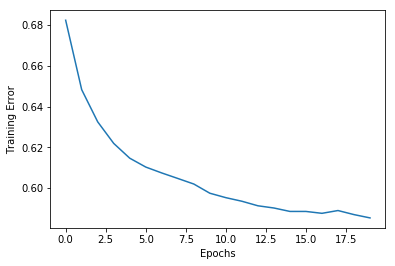

In [25]:
history = model2.fit(books.book_id, books.iloc[:,-10:], batch_size=64, epochs=20)
# model.save('regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [26]:
model2.evaluate(books.book_id, books.iloc[:,-10:], batch_size=16)

9695/9695 [==============================] - 1s 53us/sample - loss: 0.5729 - accuracy: 0.6890


[0.5728601332114123, 0.6890251]

In [27]:
# check predictions of first 10 books
np.round(model2.predict(books.book_id.head(10)))

array([[1., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 1., 1., 1., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]], dtype=float32)

## Check accuracy for only the romance tag

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
y_pred = np.round(model2.predict(books.book_id))

In [30]:
rom_true = books.romance
rom_pred = y_pred[:,-2]

In [31]:
print(classification_report(rom_true, rom_pred))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73      5444
           1       0.67      0.30      0.41      4251

   micro avg       0.63      0.63      0.63      9695
   macro avg       0.64      0.59      0.57      9695
weighted avg       0.64      0.63      0.59      9695



In [32]:
pd.DataFrame(confusion_matrix(rom_true, rom_pred))

,0,1
0,4811,633
1,2973,1278


### more to come on this...
planning to go a little deeper here

## Visualise embeddings

In [33]:
item_em = model.get_layer('Item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [34]:
item_em_weights.shape

(10000, 10)

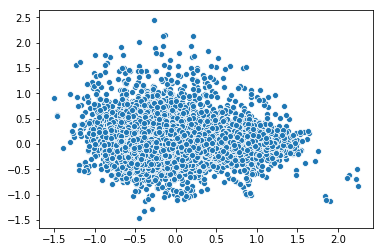

In [35]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [36]:
item_em_weights = item_em_weights / np.linalg.norm(item_em_weights, axis = 1).reshape((-1, 1))
item_em_weights[0][:10]
np.sum(np.square(item_em_weights[0]))

0.9999999

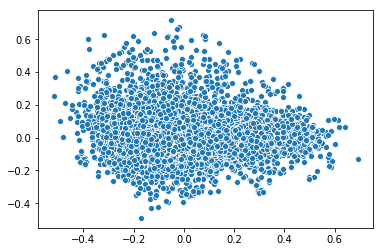

In [37]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
tnse_results = tsne.fit_transform(item_em_weights)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.035209
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.954117
[t-SNE] KL divergence after 1000 iterations: 2.220670


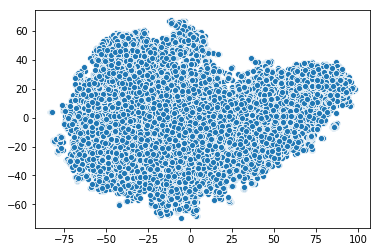

In [39]:
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

## Making recommendations

In [40]:
# Creating dataset for making recommendations for the first user
item_data = np.array(list(set(train.book_id)))
item_data[:5]

array([0, 1, 2, 3, 4])

In [41]:
user = np.array([1 for i in range(len(item_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [42]:
predictions = model.predict([user, item_data])

predictions = np.array([a[0] for a in predictions])

# get top 5 predictions
recommended_book_ids = (-predictions).argsort()[:5]

recommended_book_ids

array([8945, 6589, 5375, 6088, 9530], dtype=int64)

In [43]:
# print predicted scores
predictions[recommended_book_ids]

array([5.550216 , 5.5204053, 5.5200944, 5.5073757, 5.4924297],
      dtype=float32)

In [44]:
books[books['book_id'].isin(recommended_book_ids)]

,book_id,original_title,language_code,adult,adult-fiction,adventure,book-club,contemporary,fantasy,fiction,mystery,romance,young-adult
6420,6589,The Authoritative Calvin and Hobbes,eng,0,0,1,0,0,1,1,0,0,1
8682,8945,دیوان‎‎ [Dīvān],eng,0,0,0,0,0,0,1,0,0,0
9245,9530,Crush,eng,1,1,0,0,1,0,1,0,1,0
